In [24]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
DATASET = 'tbi'
PMODEL = 'log'
SPLIT_SEED = 0
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}/{PMODEL}/seed_{SPLIT_SEED}'

In [26]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [27]:
results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(0, 9, 2)] + ['aps', 'auc', 'acc', 'f1', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None):
    pred_proba_args = (X_test,)
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    f1 = metrics.f1_score(y_test, model.predict(X_test))
    results[model_name] = spec_scores + [apc, auc, acc, f1, model_args]

In [28]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET != 'csi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET != 'csi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        else:
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [29]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [30]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        results['f1'] = metrics.f1_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

### training propensity model

In [31]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

In [32]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])

X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [33]:
# prop_model = LogisticRegressionCV(Cs=10, penalty='l2', solver='liblinear', scoring='roc_auc', cv=10)
# prop_model.fit(X_prop_train_full, y_prop_train_full)
# prop_model = LogisticRegression(C=2.7825594, penalty='l2', solver='liblinear')
# prop_model.fit(X_prop_train_full, y_prop_train_full)

if PMODEL == 'gbp':
    prop_model = GradientBoostingClassifier()
elif PMODEL == 'log':
    prop_model = LogisticRegression(C=2.7825594, penalty='l2', solver='liblinear')

prop_model.fit(X_prop_train_full, y_prop_train_full)

LogisticRegression(C=2.7825594, solver='liblinear')

In [34]:
# prop_model.C_

In [35]:
# prop_model.scores_[1.0].mean(axis=0)

In [36]:
# print('avg score for CV folds: ', prop_model.scores_[1.0][:, 4])

In [37]:
prop_scores_train_full = prop_model.predict_proba(X_prop_train_full)[:, 1]

### data setup

In [38]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])

X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val, prop_scores_train, prop_scores_val = (
    model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, prop_scores_train_full, test_size=0.25, random_state=SPLIT_SEED))

X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

In [39]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])

cls_ratio_train_young = cls_ratio(y_train_young)
cls_ratio_train_old = cls_ratio(y_train_old)
cls_ratio_train = cls_ratio(y_train)

sw_train_young = y_train_young * cls_ratio_train_young + 1
sw_train_old = y_train_old * cls_ratio_train_old + 1
sw_train = y_train * cls_ratio_train + 1

sw_train_full_young = y_train_full_young * cls_ratio_train_young + 1
sw_train_full_old = y_train_full_old * cls_ratio_train_old + 1
sw_train_full = y_train_full * cls_ratio_train + 1

In [40]:
max_leaf_nodes_options = [8, 12, 16]
tao_iter_options = [1, 5]

In [41]:
def fit_models(model_cls, model_name, prop=False, tt=False, all=False):
    if tt:
        tao_iter_options_local = [0]
    elif model_cls == imodels.TaoTreeClassifier:
        tao_iter_options_local = tao_iter_options
    else:
        tao_iter_options_local = [None]

    for msize, tao_iter in itertools.product(max_leaf_nodes_options, tao_iter_options_local):
        if model_cls == DecisionTreeClassifier:
            model_args = {'max_leaf_nodes': msize}
        elif model_cls == imodels.FIGSClassifier:
            model_args = {'max_rules': msize}
        elif model_cls == imodels.TaoTreeClassifier:
            model_args = {'n_iters': tao_iter, 'model_args': {'max_leaf_nodes': msize}, 'update_scoring': 'average_precision'}

        young = model_cls(**model_args)
        old = model_cls(**model_args)
        whole = model_cls(**model_args)

        if not prop:
            young.fit(X_train_young, y_train_young, sample_weight=sw_train_young)
            old.fit(X_train_old, y_train_old, sample_weight=sw_train_old)
        else:
            young.fit(X_train, y_train, sample_weight=(1 - prop_scores_train) * sw_train)
            old.fit(X_train, y_train, sample_weight= prop_scores_train * sw_train)
        
        if tt:
            for _ in range(2):
                num_updates = young._tao_iter_cart(
                    X_train_old.values, y_train_old, young.model.tree_, 
                    X_train_young.values, y_train_young, sample_weight=sw_train_old, sample_weight_score=sw_train_young)
                if num_updates == 0:
                        break
        
            for _ in range(2):
                num_updates = old._tao_iter_cart(
                    X_train_young.values, y_train_young, old.model.tree_, 
                    X_train_old.values, y_train_old, sample_weight=sw_train_young, sample_weight_score=sw_train_old)
                if num_updates == 0:
                        break
                
        name_young = f'{model_name}_<2_{msize}'
        name_old = f'{model_name}_>2_{msize}'
        name_whole = f'{model_name}_all_{msize}'

        if tao_iter not in [None, 0] and not tt:
            name_young += f'_{tao_iter}'
            name_old += f'_{tao_iter}'
            name_whole += f'_{tao_iter}'

        log_results(young, name_young, X_val_young, y_val_young, model_args)
        log_results(old, name_old, X_val_old, y_val_old, model_args)

        if all:
            whole.fit(X_train, y_train, sw_train)
            log_results(whole, name_whole, X_val, y_val, model_args)

### CART

In [42]:
# fit_models(DecisionTreeClassifier, 'CART', all=True)

In [43]:
# fit_models(DecisionTreeClassifier, 'PCART', prop=True)

In [44]:
# fit_models(imodels.TaoTreeClassifier, 'TTCART', tt=True)

### FIGS

In [45]:
# fit_models(imodels.FIGSClassifier, 'FIGS', all=True)

In [46]:
# fit_models(imodels.FIGSClassifier, 'PFIGS', prop=True)

### TAO

In [47]:
# fit_models(imodels.TaoTreeClassifier, 'TAO', all=True)

### Validation results for all models

In [48]:
### JUST RAN EXPS
# val_df = pd.DataFrame.from_dict(results, orient='index', columns=columns)
# val_df.to_csv(oj(RESULT_PATH, 'val.csv'))

### LOADING PREVIOUSLY RUN EXPS
val_df = pd.read_csv(oj(RESULT_PATH, 'val.csv')).set_index('Unnamed: 0')
val_df['args'] = val_df['args'].apply(eval)

args = val_df['args']
best_models = {}
val_metrics = ['spec90', 'aps', 'auc']
pd.set_option('precision', 3)

def get_best_args(val_df_group, model_name):
    return val_df_group.filter(regex=model_name, axis=0).round(2).sort_values(
        by=val_metrics, kind='mergesort', ascending=False)['args'].iloc[0]

In [49]:
all_results = val_df[val_df.index.str.contains('all')]
all_results[val_metrics].style.background_gradient()

,spec90,aps,auc
Unnamed: 0,,,
CART_all_8,0.585,0.032,0.828
CART_all_12,0.640,0.033,0.832
CART_all_16,0.088,0.035,0.827
FIGS_all_8,0.000,0.041,0.740
FIGS_all_12,0.000,0.090,0.758
FIGS_all_16,0.000,0.104,0.758
TAO_all_8_1,0.000,0.047,0.740
TAO_all_8_5,0.000,0.055,0.740
TAO_all_12_1,0.000,0.058,0.741


In [50]:
best_models['cart_all'] = DecisionTreeClassifier(**get_best_args(all_results, 'CART')).fit(X_train_full, y_train_full, sw_train_full)
best_models['figs_all'] = imodels.FIGSClassifier(**get_best_args(all_results, 'FIGS')).fit(X_train_full, y_train_full, sample_weight=sw_train_full)
best_models['tao_all'] = imodels.TaoTreeClassifier(**get_best_args(all_results, 'TAO')).fit(X_train_full, y_train_full, sample_weight=sw_train_full)

### Validation results for >2 group

In [51]:
old_results = val_df[val_df.index.str.contains('>2')]
old_results[['spec90', 'aps', 'auc']].style.background_gradient()

,spec90,aps,auc
Unnamed: 0,,,
CART_>2_8,0.031,0.026,0.787
CART_>2_12,0.063,0.026,0.768
CART_>2_16,0.078,0.025,0.761
PCART_>2_8,0.000,0.027,0.804
PCART_>2_12,0.067,0.028,0.799
PCART_>2_16,0.099,0.028,0.784
FIGS_>2_8,0.000,0.034,0.819
FIGS_>2_12,0.008,0.033,0.812
FIGS_>2_16,0.000,0.034,0.813


In [52]:
best_models['cart_old'] = DecisionTreeClassifier(**get_best_args(old_results, '^CART')).fit(X_train_full_old, y_train_full_old, sw_train_full_old)
best_models['pcart_old'] = DecisionTreeClassifier(**get_best_args(old_results, '^PCART')).fit(X_train_full, y_train_full, prop_scores_train_full * sw_train_full)

best_models['figs_old'] = imodels.FIGSClassifier(**get_best_args(old_results, '^FIGS')).fit(
    X_train_full_old, y_train_full_old, sample_weight=sw_train_full_old)
best_models['pfigs_old'] = imodels.FIGSClassifier(**get_best_args(old_results, '^PFIGS')).fit(
    X_train_full, y_train_full, sample_weight=prop_scores_train_full * sw_train_full)

best_models['tao_old'] = imodels.TaoTreeClassifier(**get_best_args(old_results, '^TAO')).fit(
    X_train_full_old, y_train_full_old, sample_weight = sw_train_full_old)
best_models['pecarn_old'] = PECARNModel(young=False)

100%|██████████| 11/11 [00:00<00:00, 67.32it/s]


(0.5, 1.1)

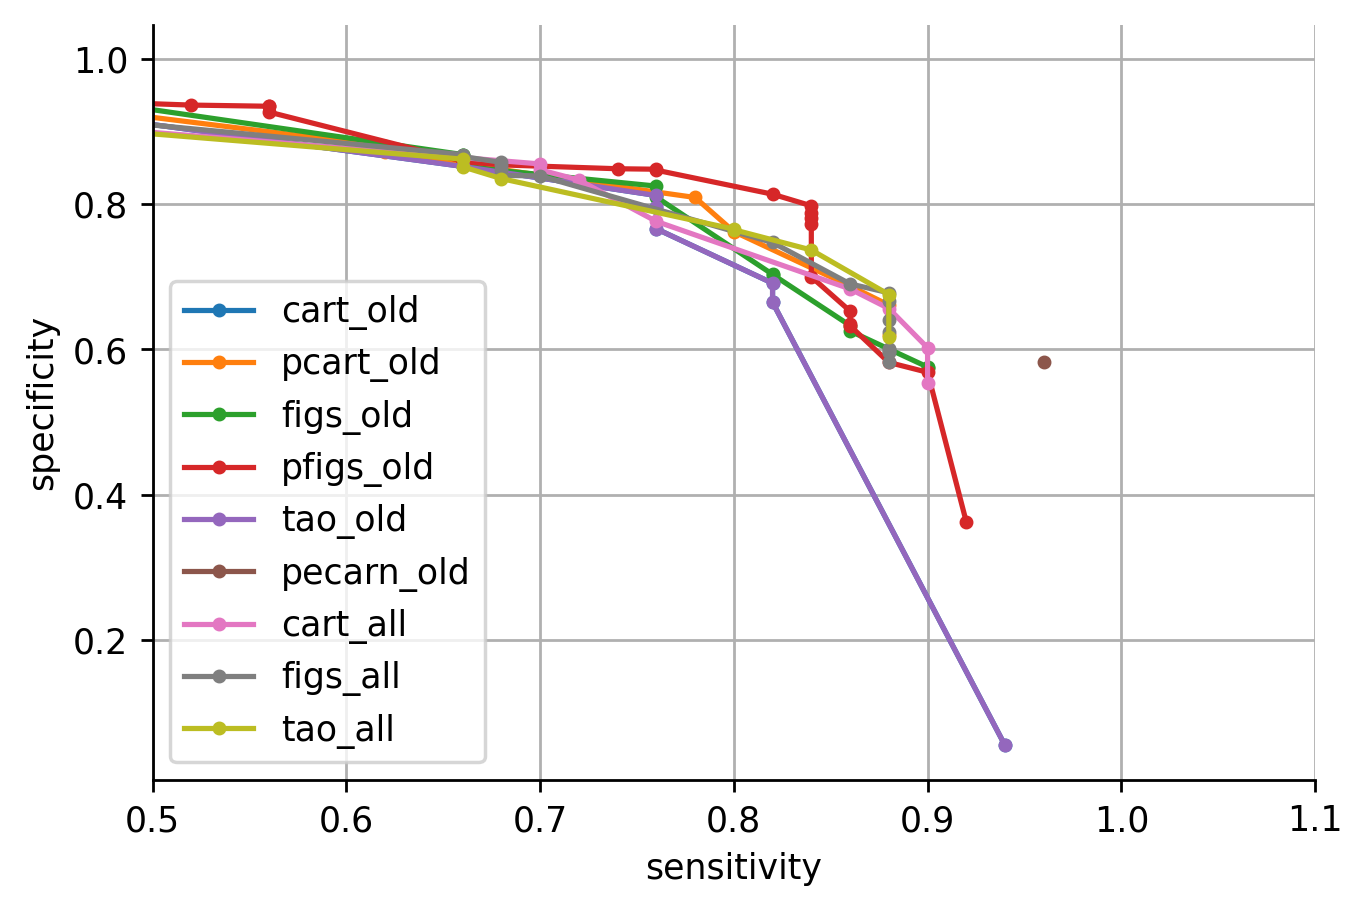

In [53]:
for model_name in ['cart_old', 'pcart_old', 'figs_old', 'pfigs_old', 'tao_old', 'pecarn_old', 'cart_all', 'figs_all', 'tao_all']:
    predict_and_save(best_models[f'{model_name}'], X_test_old, y_test_old, f'{model_name}', 'old')
plt.legend()
plt.xlim(0.5, 1.1)

### results for <2 group

In [54]:
young_results = val_df[val_df.index.str.contains('<2')]
young_results[['spec90', 'aps', 'auc']].style.background_gradient()

,spec90,aps,auc
Unnamed: 0,,,
CART_<2_8,0.830,0.044,0.913
CART_<2_12,0.828,0.043,0.908
CART_<2_16,0.814,0.041,0.886
PCART_<2_8,0.680,0.047,0.867
PCART_<2_12,0.120,0.044,0.825
PCART_<2_16,0.128,0.047,0.833
FIGS_<2_8,0.802,0.037,0.894
FIGS_<2_12,0.800,0.036,0.874
FIGS_<2_16,0.814,0.041,0.886


In [55]:
best_models['cart_young'] = DecisionTreeClassifier(**get_best_args(young_results, '^CART')).fit(X_train_full_young, y_train_full_young, sw_train_full_young)
best_models['pcart_young'] = DecisionTreeClassifier(**get_best_args(young_results, '^PCART')).fit(X_train_full, y_train_full, (1 - prop_scores_train_full) * sw_train_full)

best_models['figs_young'] = imodels.FIGSClassifier(**get_best_args(young_results, '^FIGS')).fit(
    X_train_full_young, y_train_full_young, sample_weight=sw_train_full_young)
best_models['pfigs_young'] = imodels.FIGSClassifier(**get_best_args(young_results, '^PFIGS')).fit(
    X_train_full, y_train_full, sample_weight=(1 - prop_scores_train_full) * sw_train_full)

best_models['tao_young'] = imodels.TaoTreeClassifier(**get_best_args(young_results, '^TAO')).fit(
    X_train_full_young, y_train_full_young, sample_weight = sw_train_full_young)
best_models['pecarn_young'] = PECARNModel(young=True)

100%|██████████| 10/10 [00:00<00:00, 184.06it/s]


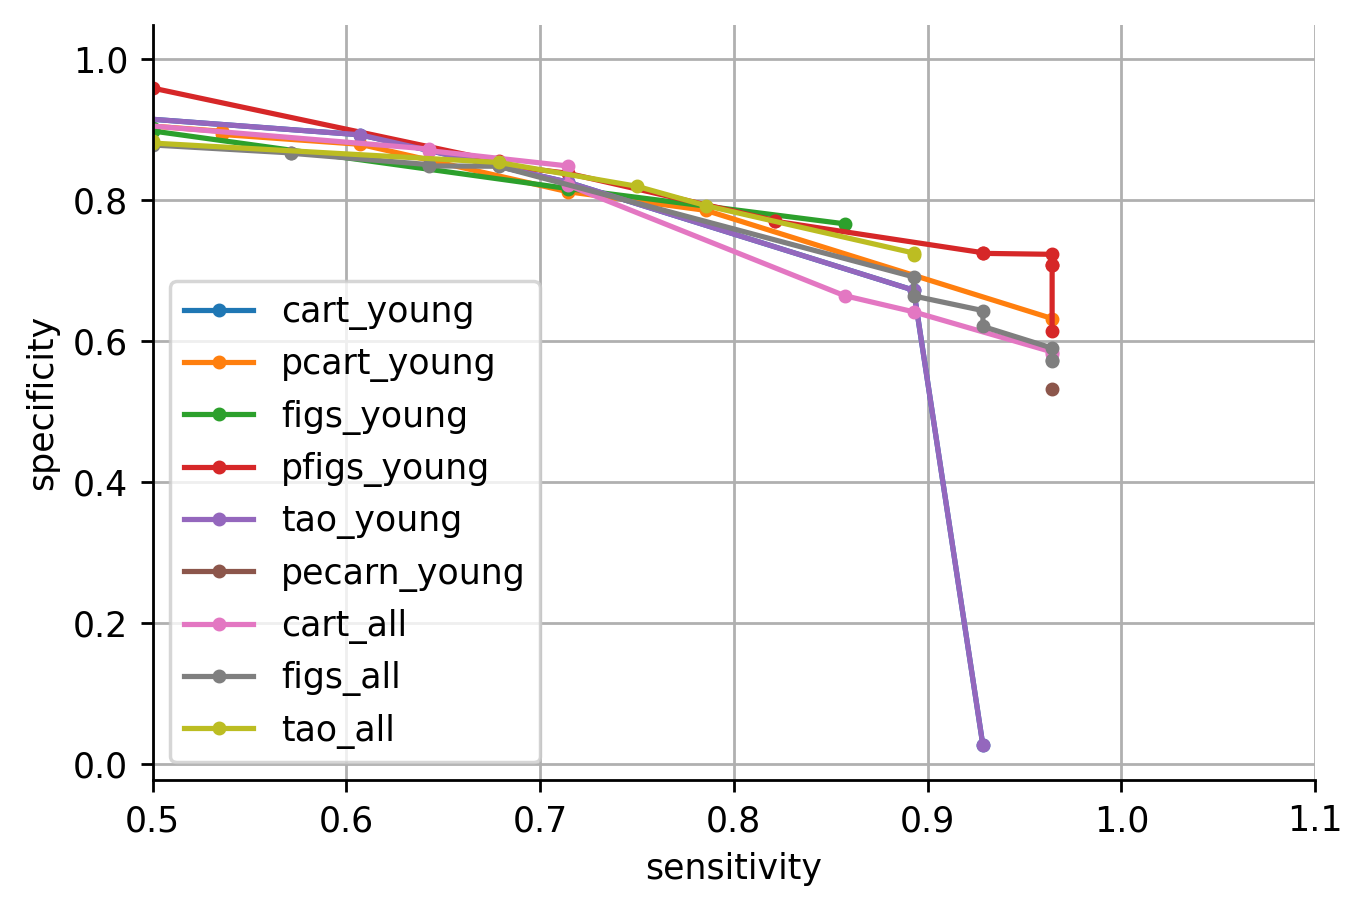

In [56]:
for model_name in ['cart_young', 'pcart_young', 'figs_young', 'pfigs_young', 'tao_young', 'pecarn_young', 'cart_all', 'figs_all', 'tao_all']:
    predict_and_save(best_models[f'{model_name}'], X_test_young, y_test_young, f'{model_name}', 'young')
plt.xlim(0.5, 1.1)
plt.legend()

### all ages results

In [57]:
for model_name in ['pcart', 'pfigs', 'pecarn', 'figs', 'tao', 'cart']:
    best_models[f'{model_name}_combine'] = TransferTree(
        best_models[f'{model_name}_young'], best_models[f'{model_name}_old'], is_group_1_test)

best_models['figmix_young'] = TransferTree(best_models['figs_young'], best_models['pfigs_old'], is_group_1_test)
best_models['figmix_old'] = TransferTree(best_models['pfigs_young'], best_models['figs_old'], is_group_1_test)

100%|██████████| 39/39 [00:00<00:00, 58.37it/s]


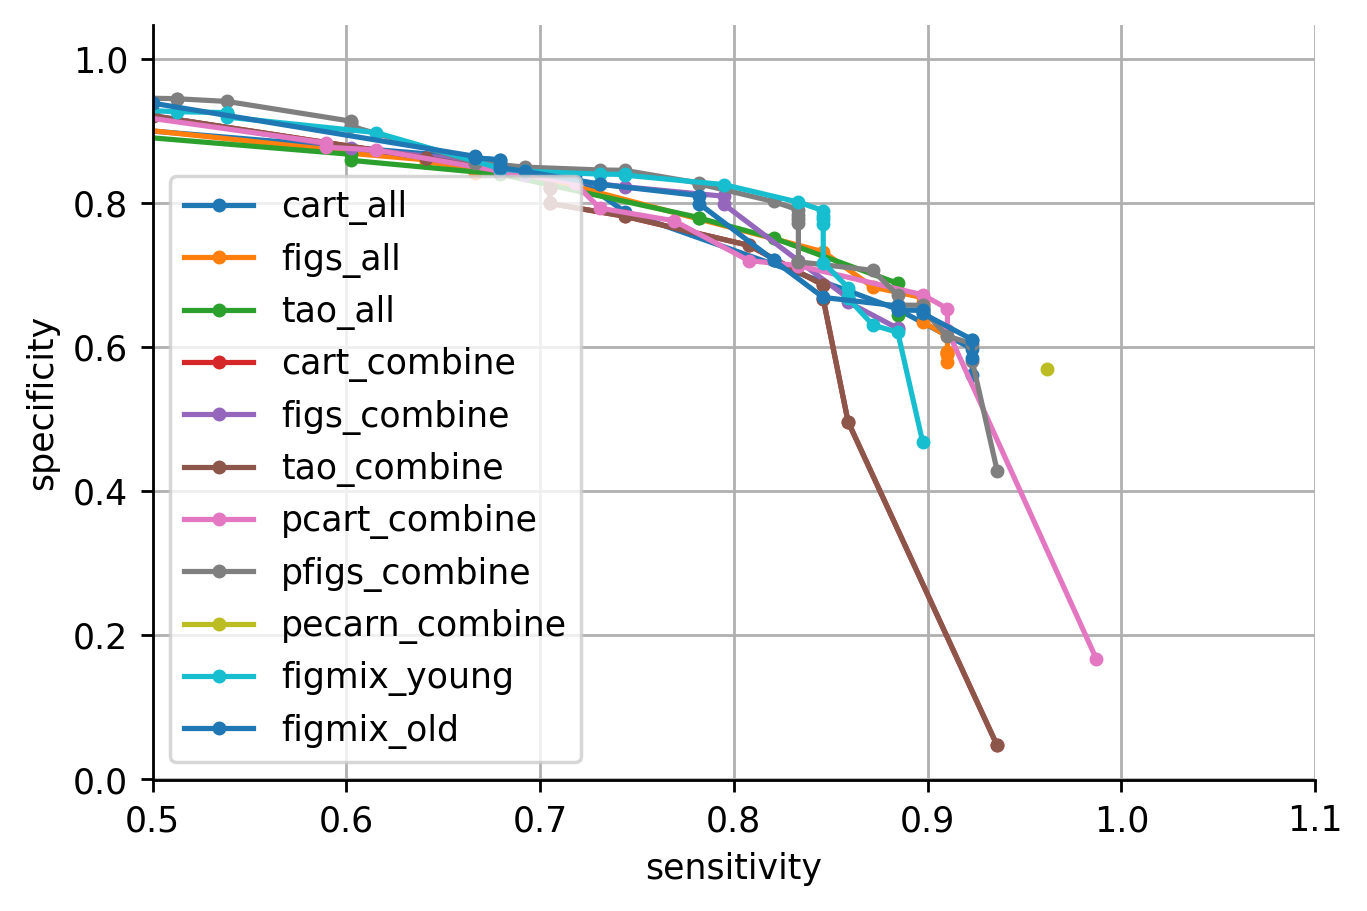

In [58]:
for model_name in ['cart_all', 'figs_all', 'tao_all', 'cart_combine', 'figs_combine',
    'tao_combine', 'pcart_combine', 'pfigs_combine', 'pecarn_combine', 'figmix_young', 'figmix_old']:
    predict_and_save(best_models[f'{model_name}'], X_test, y_test, f'{model_name}', 'all')
plt.xlim(0.5, 1.1)
plt.legend()

In [59]:
pkl.dump(best_models, open(oj(RESULT_PATH, 'best_models.pkl'), 'wb'))

### Visualizing best models

In [60]:
def vizfigs(name):
    best_models[name].feature_names_ = feature_names
    print(best_models[name])

In [61]:
vizfigs('pfigs_old')

------------
AMS <= 0.500 (Tree #0 root)
	Amnesia_verb_91.0 <= 0.500 (split)
		Val: 0.591 (leaf)
		SFxBas <= 0.500 (split)
			InjuryMech_Sports <= 0.500 (split)
				HAStart_Within 1 hr of event <= 0.500 (split)
					OSIFlank <= 0.500 (split)
						SFxPalpDepress_0.0 <= 0.500 (split)
							NeuroDCranial <= 0.500 (split)
								Val: 0.058 (leaf)
								Val: 0.822 (leaf)
							Val: 0.930 (leaf)
						Val: 0.652 (leaf)
					Val: 0.520 (leaf)
				HemaSize_Large <= 0.500 (split)
					Val: 0.473 (leaf)
					Val: 0.004 (leaf)
			Val: 0.906 (leaf)
	Val: 0.824 (leaf)

	+
ClavPar <= 0.500 (Tree #1 root)
	HemaSize_Medium <= 0.500 (split)
		Val: 0.025 (leaf)
		Val: -0.080 (leaf)
	Val: 0.171 (leaf)

	+
InjuryMech_Sports <= 0.500 (Tree #2 root)
	Val: -0.023 (leaf)
	Val: 0.072 (leaf)



In [62]:
vizfigs('pfigs_young')

------------
AMS <= 0.500 (Tree #0 root)
	HemaLoc_Occipital <= 0.500 (split)
		InjuryMech_Sports <= 0.500 (split)
			SeizLen_>15 min <= 0.500 (split)
				Val: 0.803 (leaf)
				VomitLast_>4 hrs before ED <= 0.500 (split)
					Val: 0.650 (leaf)
					VomitNbr_Twice <= 0.500 (split)
						Val: 0.021 (leaf)
						HemaSize_Not applicable <= 0.500 (split)
							Val: 0.001 (leaf)
							Val: 0.860 (leaf)
			ClavOcc <= 0.500 (split)
				AgeInMonth <= 6.500 (split)
					Val: 0.506 (leaf)
					InjuryMech_ObjStruckHead <= 0.500 (split)
						Val: 0.134 (leaf)
						Val: 0.927 (leaf)
				Val: 0.757 (leaf)
		Val: 0.701 (leaf)
	Val: 0.826 (leaf)

	+
InjuryMech_FallToGround <= 0.500 (Tree #1 root)
	VomitLast_>4 hrs before ED <= 0.500 (split)
		Val: 0.140 (leaf)
		Val: -0.040 (leaf)
	Val: 0.224 (leaf)



In [63]:
vizfigs('figs_all')

------------
AMS <= 0.500 (Tree #0 root)
	InjuryMech_Sports <= 0.500 (split)
		SFxBas <= 0.500 (split)
			Amnesia_verb_91.0 <= 0.500 (split)
				High_impact_InjSev_Moderate <= 0.500 (split)
					Val: 0.574 (leaf)
					InjuryMech_Assault <= 0.500 (split)
						NeuroDMotor <= 0.500 (split)
							Val: 0.021 (leaf)
							Val: 0.832 (leaf)
						Val: 0.755 (leaf)
				VomitLast_>4 hrs before ED <= 0.500 (split)
					AgeInMonth <= 89.500 (split)
						Val: 0.724 (leaf)
						Val: 0.005 (leaf)
					HAStart_Within 1 hr of event <= 0.500 (split)
						OSIFlank <= 0.500 (split)
							HemaLoc_Occipital <= 0.500 (split)
								InjuryMech_RanIntoStatObj <= 0.500 (split)
									Val: 0.029 (leaf)
									ClavFace <= 0.500 (split)
										Val: 0.024 (leaf)
										Val: 0.489 (leaf)
								SeizLen_Not applicable <= 0.500 (split)
									Val: 0.375 (leaf)
									Val: 0.000 (leaf)
							Val: 0.675 (leaf)
						Val: 0.461 (leaf)
			Val: 0.922 (leaf)
		Val: 0.580 (leaf)
	Val: 0.825 (leaf)

	

### understanding propensity model

- main features that determine scores

In [64]:
nonzero_ind = np.nonzero(prop_model.coef_[0])[0]
nonzero_ind_sorted = nonzero_ind[np.argsort(prop_model.coef_[0][nonzero_ind])]
prop_model_coefs = pd.DataFrame(prop_model.coef_[0][nonzero_ind_sorted], index=X_df_prop.columns[nonzero_ind_sorted])

In [65]:
important_prop_features = pd.concat((prop_model_coefs.iloc[:10], prop_model_coefs.iloc[-10:]))
important_prop_features.style.background_gradient()

,0
FontBulg_nan,-2.416
VomitStart_Before head injury,-1.786
InjuryMech_FallStair,-1.565
HA_verb_91.0,-1.529
Amnesia_verb_91.0,-1.306
InjuryMech_FallElev,-1.281
HAStart_Not applicable,-1.135
HASeverity_Not applicable,-1.135
InjuryMech_Other,-1.067
SeizLen_5-15 min,-1.033


- distribution of scores

<AxesSubplot:xlabel='prop_score', ylabel='Density'>

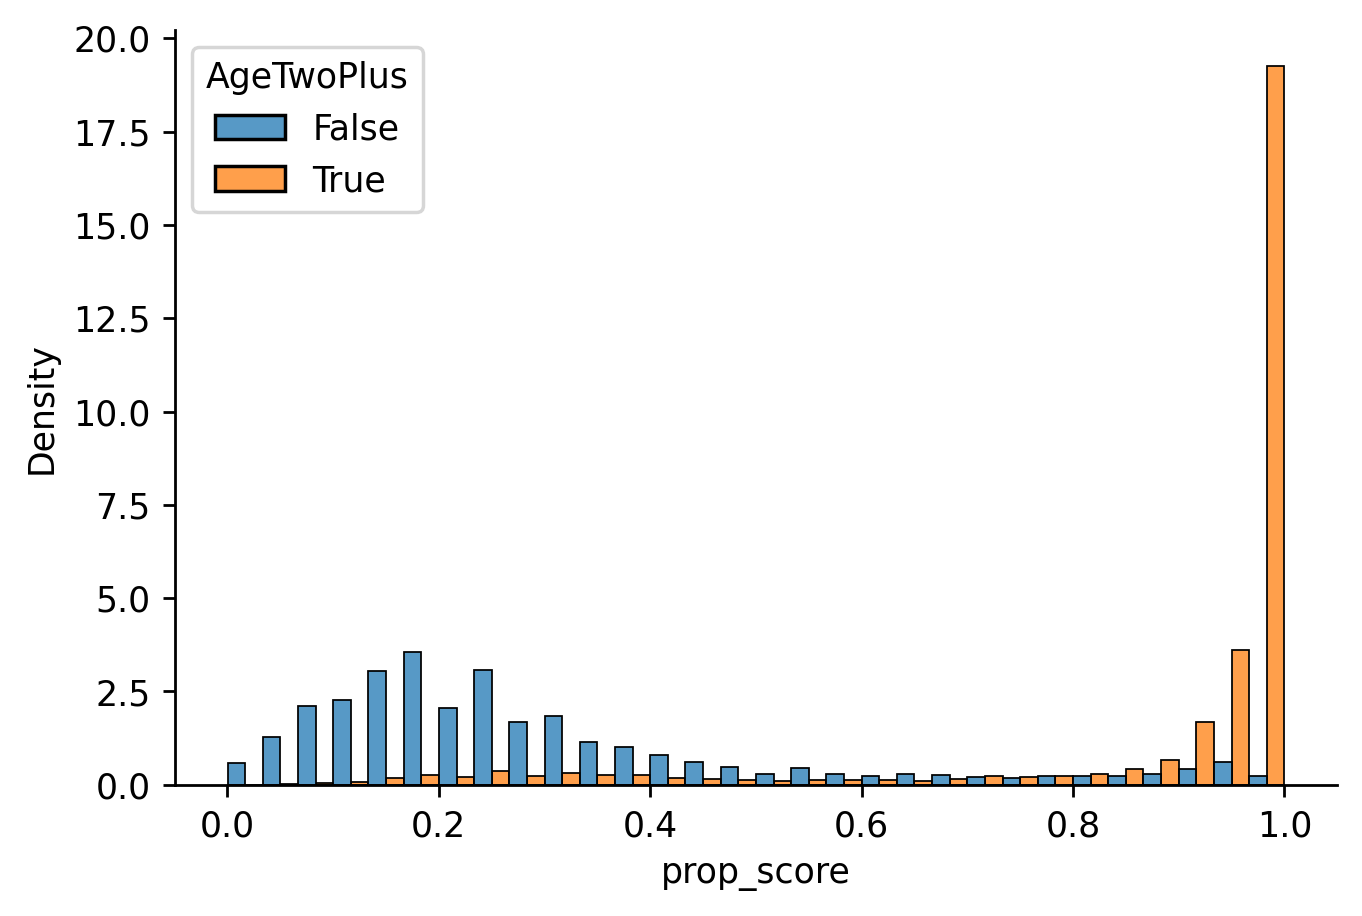

In [67]:
X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.2, random_state=SPLIT_SEED)
X_df_prop_raw_train_full['prop_score'] = prop_scores_train_full
X_df_prop_raw_train_full['AgeTwoPlus'] = X_df_prop_raw_train_full['AgeinYears'] >= 2
sns.histplot(data=X_df_prop_raw_train_full, x='prop_score', hue='AgeTwoPlus', multiple='dodge', stat="density", common_norm=False, bins=30)

- relationship between scores and age in months

In [68]:
X_df_prop_raw_train_full_younger = X_df_prop_raw_train_full[X_df_prop_raw_train_full['AgeInMonth'] < 50]

<AxesSubplot:xlabel='prop_score', ylabel='AgeInMonth'>

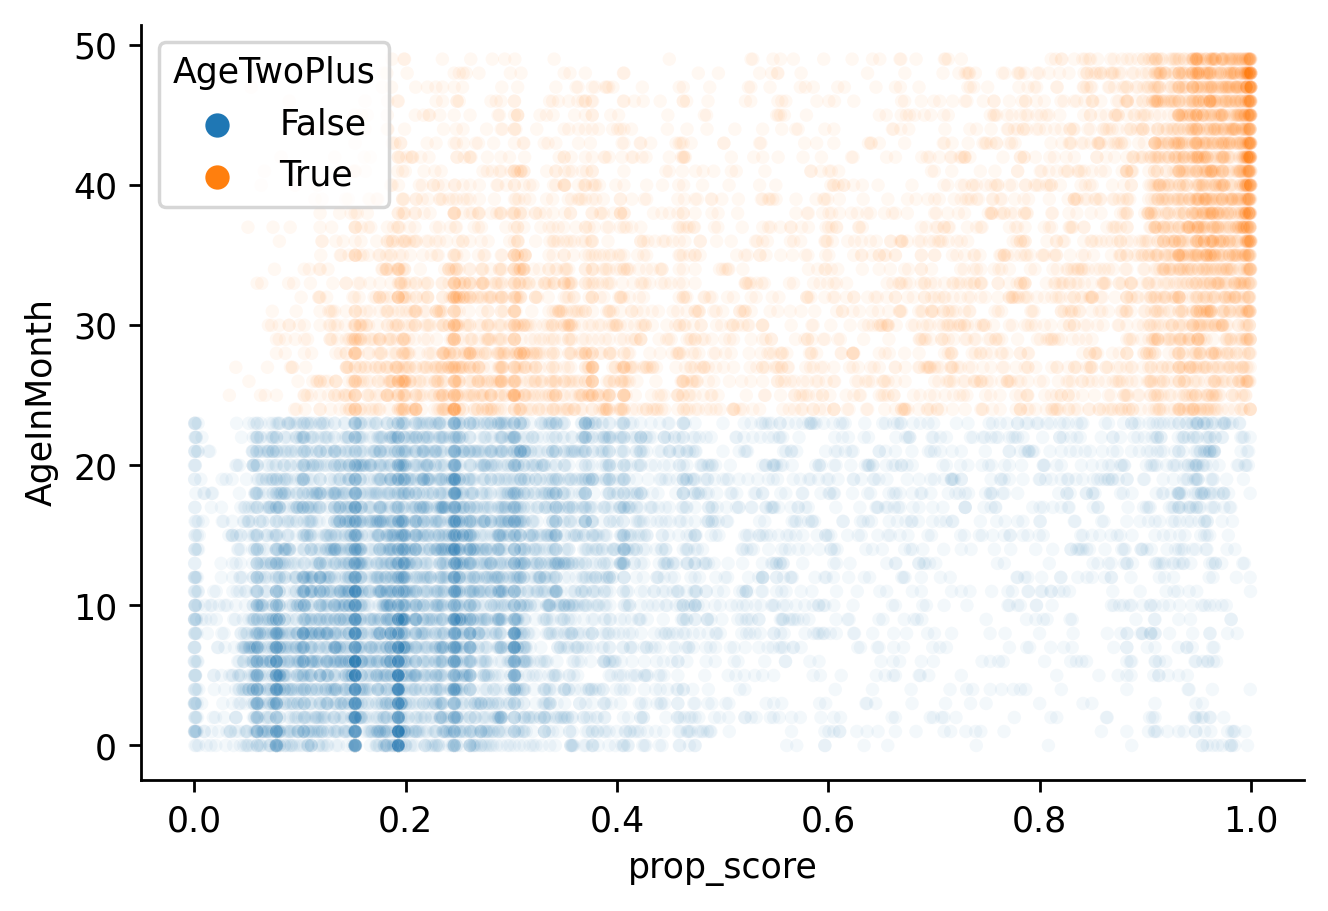

In [69]:
sns.scatterplot(data=X_df_prop_raw_train_full_younger, x='prop_score', y='AgeInMonth', hue = 'AgeTwoPlus', alpha=0.05, s=15)

- possible further analysis: dig into the cluster of patients with age over two with prop scores in (0.1, 0.4) seen above

clusters of pts with exact same prop score

In [ ]:
X_df_prop_raw_train_full['prop_score'].value_counts()

0.183    284
0.148    271
0.295    200
0.245    173
0.076    126
        ... 
0.351      1
0.999      1
0.999      1
0.313      1
0.955      1
Name: prop_score, Length: 20369, dtype: int64

In [ ]:
same_score_points = X_df_prop_raw_train_full[X_df_prop_raw_train_full['prop_score'].round(6) == 0.154315]
same_score_points.std(axis=0)[same_score_points.std(axis=0) > 0]

Series([], dtype: float64)

In [ ]:
# young_misclass = (X_df_prop_raw_train_full['prop_score'] > 0.6) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 0)
# young_class = (X_df_prop_raw_train_full['prop_score'] < 0.6) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 0)
# old_misclass = (X_df_prop_raw_train_full['prop_score'] < 0.4) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 1)
# old_class = (X_df_prop_raw_train_full['prop_score'] > 0.4) & (X_df_prop_raw_train_full['AgeTwoPlus'] == 1)

In [ ]:
# yg_diffs = X_df_prop_raw_train_full.loc[young_misclass, important_prop_features.index].describe() - X_df_prop_raw_train_full.loc[young_class, important_prop_features.index].describe()
# yg_diffs.abs().sort_values(by='mean', axis=1, ascending=False)

In [ ]:
# old_diffs = X_df_prop_raw_train_full.loc[old_misclass, important_prop_features.index].describe() - X_df_prop_raw_train_full.loc[old_class, important_prop_features.index].describe()
# old_diffs.abs().sort_values(by='mean', axis=1, ascending=False)